In [1]:
%matplotlib inline

In [2]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels

In [3]:
sys.path.append(os.path.dirname(tr.__file__))

In [4]:
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/zs_cpc_ls100/checkpoint_170.pt'
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc/checkpoint_0.pt'  # Check that baseline doesn't have the moire pattern
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc/checkpoint_10.pt'  # Check that baseline doesn't have the moire pattern
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc/checkpoint_199.pt'  # Fig baseline

# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_avgpool/checkpoint_120.pt'

# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8/checkpoint_199.pt'
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8/checkpoint_50.pt'

CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred6/checkpoint_49.pt'  # Fig improved
CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred6/checkpoint_199.pt'  # Fig improved

# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_rate0.7/checkpoint_199.pt'

# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred6_skipb1e6/checkpoint_49.pt'  # Ali plot
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8_skipb1e8/checkpoint_49.pt'  # Ali plot
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred6/checkpoint_49.pt'
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred4/checkpoint_20.pt'
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match20_pred7_sl_allopt/checkpoint_199.pt'
# CP = '/pio/scratch/2/jch/wav2vec/runs/cpc_base/ls100_cpcctc_match12_pred8_nsl2/checkpoint_135.pt'

CP = '/pio/scratch/2/i323106/wav2vec/runs/cpc/acpc-hierarchical-uniformpooling4_2/checkpoint_49.pt' # Ours

In [5]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
args.pathDB = '/pio/data/zerospeech2021/LibriSpeech-wav/train-clean-100'
# args.pathDB = '/pio/data/zerospeech2021/LibriSpeech-wav/train-clean-100_rate0.7/'
args.pathTrain = '/pio/scratch/2/jch/wav2vec/LibriSpeech100_labels_split/train_split.txt'
args.pathVal = '/pio/scratch/2/jch/wav2vec/LibriSpeech100_labels_split/test_split.txt'
args.pathPhone = '/pio/scratch/2/i323106/converted_aligned_phones.txt'
args.size_window = 20480

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loaded from cache /pio/data/zerospeech2021/LibriSpeech-wav/train-clean-100/_seqs_cache.txt successfully
10it [00:00, 94466.31it/s]Checking length...
Done, elapsed: 0.007 seconds
Scanned 10 sequences in 0.01 seconds
1 chunks computed

Joining pool
Joined process, elapsed=1.821 secs
Loading checkpoint /pio/scratch/2/i323106/wav2vec/runs/cpc/acpc-hierarchical-uniformpooling4_2/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=2, CPCCTCNumMatched=12, CPCCTCReductionFactor=4, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='LSTM', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False,

In [6]:
model.cpu()
if criterion is not None:
    criterion.cpu()
val_loader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)

In [7]:
data_iter = iter(val_loader)

In [8]:
batch_data, label = next(data_iter)
c_feature, encoded_data, _ = model(batch_data, None)

In [33]:
# plt.figure(figsize=(7, 3), dpi=150)
# plt.plot(batch_data.view(-1)[2000:15000])

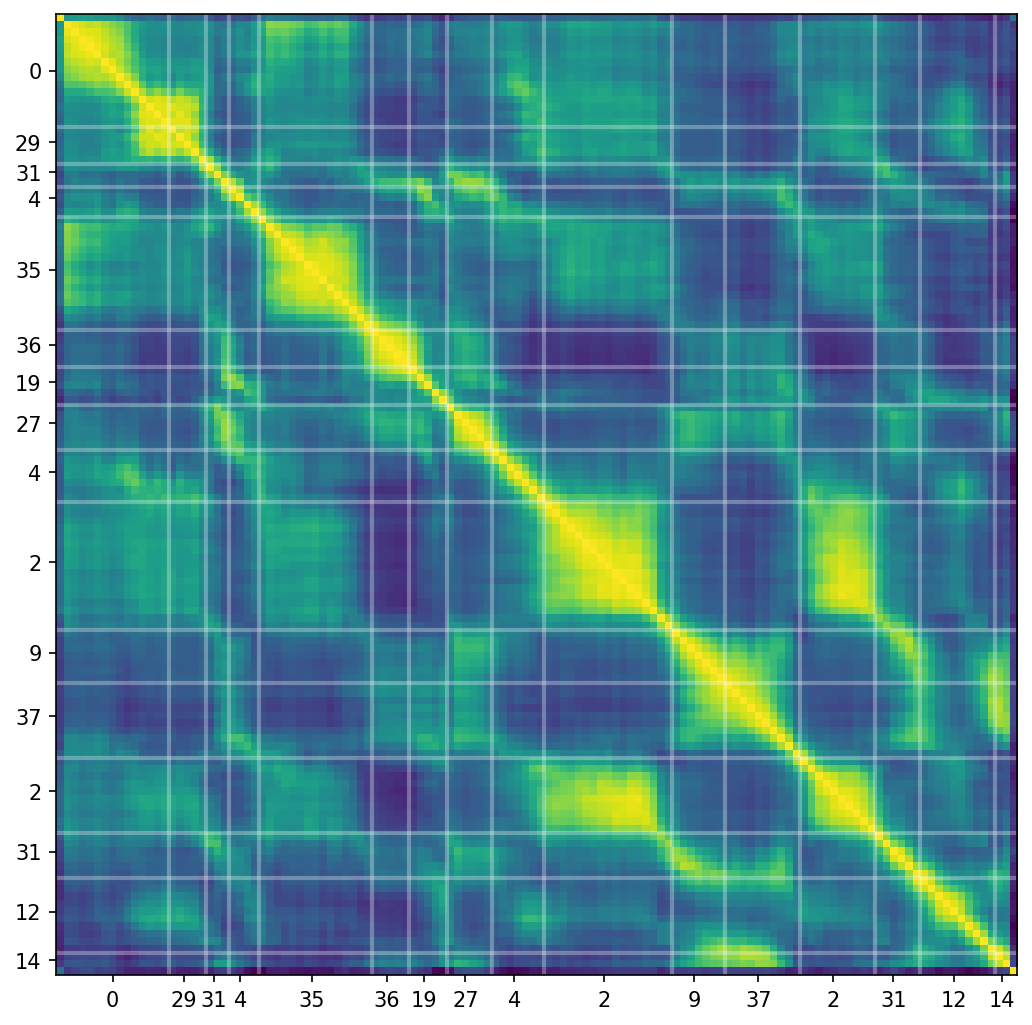

In [9]:
# the paper has these figures
features = encoded_data

trunc = 64  # or None for full plot
trunc = None

plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,:trunc].numpy()

enc = features[0, :trunc, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [str(p) for p in phones[bars[1:]]])
_ = plt.yticks(phone_locs, [str(p) for p in phones[bars[1:]]])

In [27]:
features = c_feature[0]

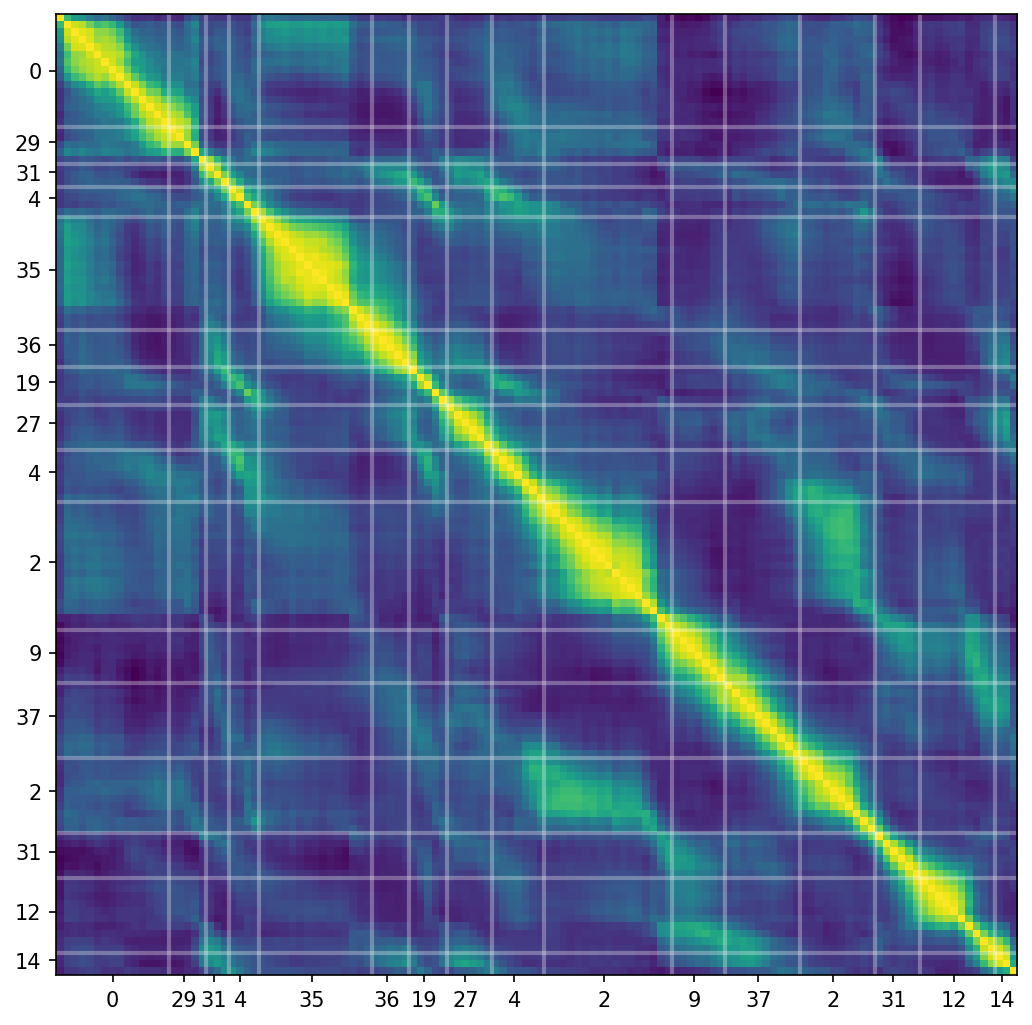

In [28]:
plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,].numpy()

enc = features[0, :, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [str(p) for p in phones[bars[1:]]])
_ = plt.yticks(phone_locs, [str(p) for p in phones[bars[1:]]])

In [12]:
features = c_feature[1]

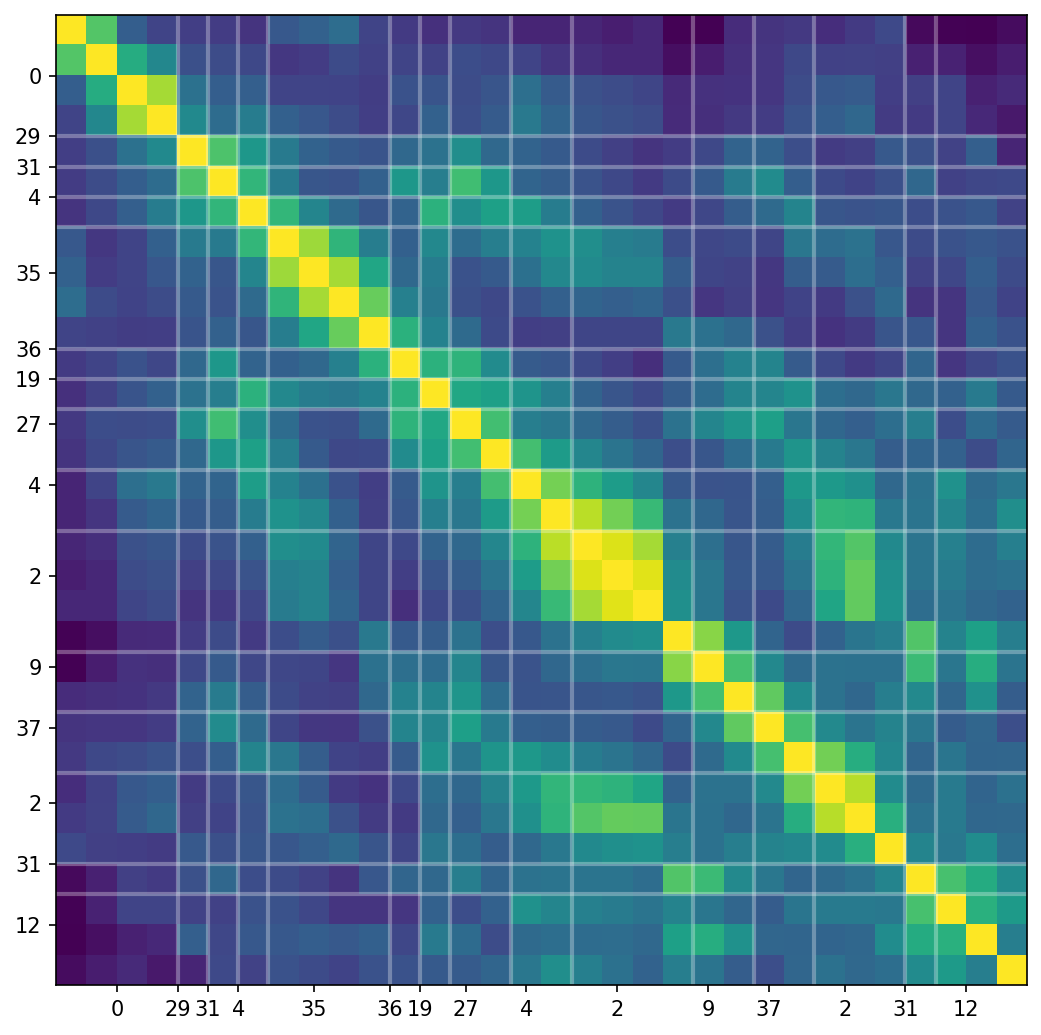

In [26]:
plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,].numpy()
phones = phones[::4]

enc = features[0, :, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [str(p) for p in phones[bars[1:]]])
_ = plt.yticks(phone_locs, [str(p) for p in phones[bars[1:]]])

In [26]:
# cFeature: after the autoregressive model
# encoded_data: output of the encoder

losses, outAcc, _, crit_locals = criterion(c_feature, encoded_data, label, return_locals=True)

TypeError: forward() got an unexpected keyword argument 'return_locals'

In [27]:
OB = 50
OS = range(OB, OB+10)
plt.figure(figsize=(30, 6))
for i, O in enumerate(OS, start=1):
    phones = label['phone'][0, O:O + args.CPCCTCNumMatched].numpy()
    plt.subplot(1, len(OS), i)
    plt.imshow(crit_locals['log_scores'][O].detach().numpy()) #, extent=(-0.5, args.))
    plt.title(str(phones))
    plt.scatter(crit_locals['aligns'][O, :], np.arange(args.CPCCTCNumMatched))
    for boundary in np.where(np.diff(phones))[0] + 0.5:
        plt.axhline(boundary, color='r')
    #plt.colorbar()
plt.tight_layout()

NameError: name 'crit_locals' is not defined

In [15]:
# plt.figure(figsize=(30, 30))
# phones = label['phone'][0,].numpy()

# enc = crit_locals['encodedData'][0, :, :].detach().numpy()
# plt.imshow((enc @ enc.T) / enc.shape[-1])
# for boundary in np.where(np.diff(phones))[0] + 0.5:
#     plt.axhline(boundary, color='r')
#     plt.axvline(boundary, color='r')
# #plt.colorbar()
# plt.tight_layout()